### An implementation of CNN without using any Neural Network libraries
The implementation consists of a single convolutional layer with tanh activation. <br>
This is followed by a flattened layer which is then passed to a fully connected layer. <br>
Finally the output is passed through a sigmoid activation layer and the loss used is binary cross entropy. <br>
The implentation is tested on a small subset of the MNIST dataset with 2 classes

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.data
from skimage.transform import resize
from skimage.color import rgb2gray

from math import e
from scipy import misc
import os
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

### Read and Prepare the Data
Take a small subset of the MNIST dataset with just 2 classes because the CNN implemented here is not very robust and currently only implemented for binary classification

In [262]:
mnist = pd.read_csv('train.csv')

In [289]:
mnist_binary = mnist[mnist['label'] == 0][0:2000].append(mnist[mnist['label'] == 1][0:2000]).reset_index(drop=True)

In [290]:
mnist_labels = mnist_binary['label'].values
mnist_labels = np.asarray([[i] for i in mnist_labels])
mnist_data = mnist_binary.drop('label', axis=1).values

In [291]:
mnist_data = np.asarray([np.reshape(i, (28,28)) for i in mnist_data])

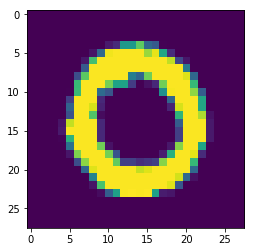

In [292]:
plt.imshow(mnist_data[0])

In [293]:
train_images, test_images, train_labels, test_labels = train_test_split(mnist_data, mnist_labels, train_size=0.80, 
                                                                       stratify=mnist_labels)

In [294]:
train_images_scaled = train_images/255.0
test_images_scaled = test_images/255.0

# CNN

 ### Function to perform the actual convolution operation along with activation

In [269]:
def conv_operation(test_array, filt, filter_shape, activation=None):
    conv_result = [[] for i in range((test_array.shape[0]-filter_shape)+1)]

    for i in range(test_array.shape[0]):
        for j in range(test_array.shape[1]):
            if (i+filter_shape<=test_array.shape[0]) and (j+filter_shape<=test_array.shape[1]):
                conv_val = np.sum(test_array[i:(i+filter_shape), j:(j+filter_shape)] * filt)
                if activation == 'ReLU':
                    if conv_val > 0:
                        conv_result[i].append(conv_val)
                    else:
                        conv_result[i].append(0)
                elif activation == 'tanh':
                    tanh_val = ((e**conv_val) - (e**(-conv_val)))/((e**conv_val) + (e**(-conv_val)))
                    conv_result[i].append(tanh_val)
                else:
                    conv_result[i].append(conv_val)
                    
    return np.asarray(conv_result)

### Function to initialize filters to a random normal distribution

In [270]:
def make_initial_filters(num, size):
    return np.random.randn(num, size, size)

### Function to create convolution block and generate feature maps using the conv_operation function

In [271]:
def cnn2d_block(inp_array, filter_shape, filters, activation):
    feature_maps = []
    
    for i in range(len(filters)):
        feature_maps.append(conv_operation(inp_array, filters[i], filter_shape, activation))
        
    return np.asarray(feature_maps)

### Activation Functions
3 options: ReLU and tanh and sigmoid

tanh

In [272]:
def tanh_actv(feature_maps):
    '''
    hyperbolic tangent (tanh) activation function applied to all the feature maps
    tanh(x) = ((e**x) - (e**(-x))) / ((e**x) + (e**(-x)))
    '''
    
    tanh_f_maps = []
    
    for f_map in feature_maps:
        multiple_rows = []
        for i in f_map:
            row = []
            for j in i:
                row.append(np.tanh(j))
            multiple_rows.append(row)
        tanh_f_maps.append(multiple_rows)
        
    return np.asarray(tanh_f_maps)

In [273]:
def derivative_tanh_actv(feature_maps):
    '''
    derivative of the tanh activation function used during backpropagation
    '''
    derv_tanh_f_maps = []
    
    for f_map in feature_maps:
        derv_tanh_f_maps.append(1 - np.tanh(f_map) ** 2)
    
    #print(derv_tanh_f_maps)
    return np.asarray(derv_tanh_f_maps) 

ReLU

In [274]:
def relu_actv(feature_maps):
    '''
    rectified linear units (ReLU) activation function applied to all feature maps
    relu(x) = max(x, 0)
    -> incomplete: derivative not implemented
    '''
    
    relu_f_maps = []
    
    for f_map in feature_maps:
        multiple_rows = []
        for i in f_map:
            row = []
            for j in i:
                row.append(np.max([j, 0]))
            multiple_rows.append(row)
        relu_f_maps.append(multiple_rows)
        
    return np.asarray(relu_f_maps)

Sigmoid

In [275]:
def sigmoid(dense_layer_output):
    '''
    Sigmoid Function
    1 / (1+e^(-x))
    '''
    return 1/(1+(np.power(e, np.multiply(-1, dense_layer_output))))

In [276]:
def derivative_sigmoid(dense_layer_output):
    '''
    Derivative Sigmoid
    sigmoid * (1-sigmoid)
    '''
    sig = sigmoid(dense_layer_output)
    return sig*(1-sig)

### Flatten Input Layer

In [277]:
def flatten(feature_maps):
    return np.expand_dims(np.reshape(feature_maps,-1),axis=0)

### Dense Layer

In [278]:
def dense_layer(inp_arr, weights):
    return inp_arr.dot(weights)

### Binary Cross  Entropy cost function
−( y * log(p) + (1−y)*log(1−p) )

In [279]:
def binary_cross_entropy_cost(preds_proba, true):
    first_term = true*np.log(preds_proba)
    second_term = (1-true)*np.log(1-preds_proba)
    return -(first_term + second_term)

### Single Forward pass or Make Predictions

In [296]:
def make_predictions(model, x_data):
    results = {'preds': []}
    for i in range(len(x_data)):
        c1 = cnn2d_block(x_data[i], model['f'][0].shape[2], model['f'][0], None)
        c1_tanh = tanh_actv(c1)
        f1 = flatten(c1_tanh)
        d1 = dense_layer(f1, model['w'][0])
        preds_sigmoid = sigmoid(d1)
        results['preds'].append(float(np.squeeze(preds_sigmoid > 0.5)))
    return results

### Forward Pass, Backward Pass, Training
This is the most important part of the whole implementation

In [281]:
def cnn_train(x_data, true_y, model, learning_rate, epochs):
        accuracy_dict = {}
        costs_dict = {}
        
        for epo in tqdm_notebook(range(epochs)):
            print('Epoch: ', epo, end="\n")
            
            preds = []
            costs = []
            
            for i in range(len(x_data)):
                '''
                FORWARD PASS
                '''
                c1 = cnn2d_block(x_data[i], model['f'][0].shape[2], model['f'][0], None) #convolution opration
                c1_shape = c1.shape[1] #store shape to use later in backward pass
                c1_tanh = tanh_actv(c1) #tanh activation
                f1 = flatten(c1_tanh) #flatten to pass to fc layer
                d1 = dense_layer(f1, model['w'][0]) #fc layer
                preds_sigmoid = sigmoid(d1) #pass the output of the fc layer through sigmoid activation
                
                #store the predictions to calculate accuracy after each epoch
                preds.append(float(np.squeeze(preds_sigmoid > 0.5)))
                
                
                '''
                BINARY CROSS ENTROPY COST
                '''
                cost = binary_cross_entropy_cost(preds_sigmoid, true_y[i])
                
                #store the costs for each iteration
                costs.append(float(np.squeeze(cost)))
            
                
                '''
                BACK PROPAGATION
                '''
                gradient1_1 = preds_sigmoid - true_y[i] #derivative of loss
                gradient1_2 = derivative_sigmoid(d1) #derivative of sigmoid
                #dot product of flattened layer with the loss dervative
                #weights of the last fully connected layer will be updated based on this
                gradient1 = f1.T.dot(gradient1_1*gradient1_2) 
            
                gradient2_1 = (gradient1_1).dot(model['w'][0].T)
                gradient2_2 = x_data[i]
                gradient2_3 = derivative_tanh_actv(c1) #derivative of tanh layer
                
                #gradient of a convolution layer can be represented as a fully convolution operation
                #a fully convolution operation is slightly altered kind of convolution involving some roations
                # https://medium.com/@2017csm1006/forward-and-backpropagation-in-convolutional-neural-network-4dfa96d7b37e
                gradient2_1_reshape = np.reshape(gradient2_1, (c1_shape,c1_shape))
                gradient2_temp = gradient2_1_reshape*gradient2_3[0]
                gradient2 = np.rot90(conv_operation(gradient2_2, np.rot90(gradient2_temp, 2), 
                                                    gradient2_temp.shape[0], None), 2)
            
            
                '''
                STOCHASTIC GRADIENT DESCENT
                Updating the gradients for each data point
                Faster learning but more unstable
                '''
                model['f'][0] = model['f'][0] - (gradient2*learning_rate)
                model['w'][0] = model['w'][0] - (gradient1*learning_rate)
                
            
            accuracy = accuracy_score(preds, true_y.flatten())
            accuracy_dict[epo] = accuracy
            costs_dict[epo] = costs
                
            print("Training Accuracy: ", accuracy)
            print("========"*12, end="\n\n\n")
            
        return accuracy_dict, costs_dict

### Initialize the weights to random normal distributions before training

In [305]:
#dense layer weights and filters initialized
filters = make_initial_filters(1, 3)*2
w1_shape = (train_images_scaled.shape[1]-filters.shape[1]) + 1
w1 = np.random.randn(w1_shape**2,1) *2

model = {
    'f' : [filters],
    'w' : [w1]
}

Make predictions with the random weights just to check

In [306]:
predictions_with_random_weights = make_predictions(model, train_images_scaled)
accuracy_score(predictions_with_random_weights['preds'], train_labels.flatten()) * 100 

49.90625

### Training the model

In [307]:
accuracy_history, costs_history = cnn_train(train_images_scaled, train_labels, model, learning_rate = 0.1, epochs=5)

Epoch:  0


/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Training Accuracy:  0.875


Epoch:  1
Training Accuracy:  0.9478125


Epoch:  2
Training Accuracy:  0.9740625


Epoch:  3
Training Accuracy:  0.9809375


Epoch:  4
Training Accuracy:  0.9865625




#### Plot how accuracy on the training set changed during training

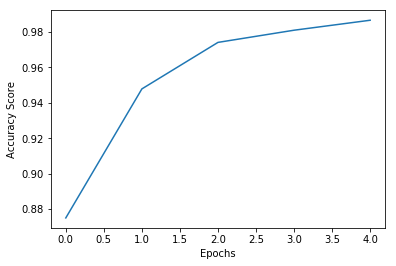

In [308]:
plt.plot(list(accuracy_history.keys()), list(accuracy_history.values()))
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.show()

### Predictions on TEST SET

In [309]:
test_preds = make_predictions(model, test_images_scaled)

In [310]:
accuracy_score(test_preds['preds'], test_labels.flatten()) * 100 

97.75